# Assignment 1: Getting Started with Machine Learning
---------------------------------------------------------

Not that some of the conclusion we made in this notebook are incorrect and have been refined/rectified in the writeup. The results themselves are okay.

Let us install some packages and import some things to get started.

In [ ]:
%pip install ucimlrepo  # Install the ucimlrepo package to access the datasets

In [719]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from ucimlrepo import fetch_ucirepo

%matplotlib inline
plt.rc('axes', axisbelow=True)
pd.options.display.max_columns = None

## Task 1: Acquire, preprocess, and analyze the data
### 1.1 Loading the datasets
Let us fetch the datasets as `pandas` dataframes. This is simple with the `fetch_ucirepo` interface as it already returns a dataframe!

In [3]:
diabetes = fetch_ucirepo(id=891).data.original
temperature = fetch_ucirepo(id=925).data.original

### 1.2 Preparing the datasets
#### 1.2.1 Preparing _Infrared Thermography Temperature_
Let us first check if there are any null values in the dataset.

In [ ]:
temperature.loc[temperature.isnull().any(axis=1)]

,SubjectID,aveOralF,aveOralM,Gender,Age,Ethnicity,T_atm,Humidity,Distance,T_offset1,Max1R13_1,Max1L13_1,aveAllR13_1,aveAllL13_1,T_RC1,T_RC_Dry1,T_RC_Wet1,T_RC_Max1,T_LC1,T_LC_Dry1,T_LC_Wet1,T_LC_Max1,RCC1,LCC1,canthiMax1,canthi4Max1,T_FHCC1,T_FHRC1,T_FHLC1,T_FHBC1,T_FHTC1,T_FH_Max1,T_FHC_Max1,T_Max1,T_OR1,T_OR_Max1
902,180313-05,36.95,36.79,Female,18-20,White,23.9,15.3,NaN,0.8100,35.735,35.4150,35.0525,34.6275,35.7000,35.7000,35.5200,35.7350,35.4450,35.4100,35.290,35.460,35.3150,35.010,35.735,35.6975,34.5750,34.73,34.675,34.7075,34.77,35.3900,35.1925,36.0075,35.8675,35.895
903,180313-06,37.40,37.49,Male,18-20,White,23.9,15.3,NaN,0.7775,35.620,35.6275,34.3650,33.8125,35.6675,35.5975,35.5925,35.7025,35.6425,35.5975,35.505,35.685,35.3475,35.295,35.725,35.6950,33.4375,33.59,33.840,33.1125,33.35,34.8675,34.4825,36.3350,36.0425,36.080


We see that there are two rows where the "Distance" feature is null/NaN for this dataset. Let us fill this in simply via the mean of the values.

From the description of the dataset, we also saw that there are a few categorical features, including the gender, the ethnicity, and the age of the subject. Let us also transform these features into `pandas` categorical types for ease of later handling.

In [384]:
temperature_cleaned = temperature.copy()
temp_features = []
temp_features_scaled = []

temperature_cleaned = temperature_cleaned.drop(columns=["SubjectID", "aveOralF"])

# Fill missing values in Distance with the mean
temperature_cleaned["Distance"] = temperature_cleaned["Distance"].fillna(temperature_cleaned["Distance"].mean())

# Scale numeric features
for col in temperature_cleaned.drop(columns=["aveOralM"]).select_dtypes("number").columns:
  temperature_cleaned[col + "_Scaled"] = (temperature_cleaned[col] - temperature_cleaned[col].mean()) / temperature_cleaned[col].std()
  temp_features.append(col + "_Scaled")
  temp_features_scaled.append(col + "_Scaled")

# Age groups 21-25 and 26-30 should be combined into one group 21-30
temperature_cleaned['Age'] = temperature_cleaned["Age"].replace(['21-25', '26-30'], '21-30')

# Ordinal/label encoding for categorical features
for col in ["Gender", "Ethnicity", "Age"]:
  temperature_cleaned[col + "Cat"] = temperature_cleaned[col].astype('category')
  temperature_cleaned[col] = temperature_cleaned[col + "Cat"].cat.codes
  temp_features.append(col)


#### 1.2.2 Preparing _CDC Diabetes Health Indicators_
From the description of the dataset, we saw that all features are already numerical. Let us check if there are any null values.

In [ ]:
diabetes.loc[diabetes.isnull().any(axis=1)]

,ID,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income


Looks good! As with the previous dataset, let us drop the IDs as they are not necessary for analysis.

In [5]:
diabetes_cleaned = diabetes.copy().drop(columns=["ID"])

### 1.3 Basic statistics and preliminary analysis
#### 1.3.1 Basic statistics for _Infrared Thermography Temperature_
Let us check the distribution of the target.

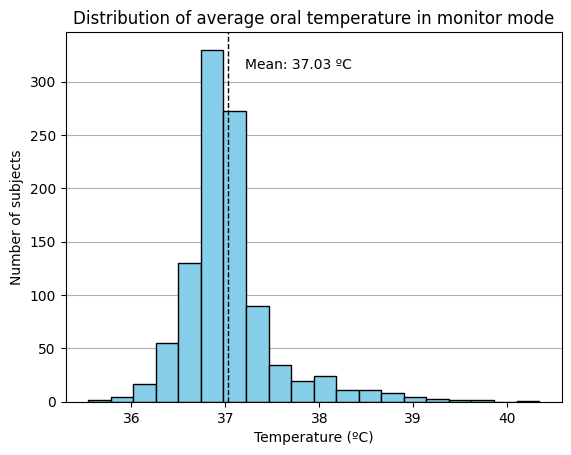

In [254]:
temperature_cleaned["aveOralM"].plot.hist(
  bins=20, color='skyblue', edgecolor='black',
  xlabel="Temperature (ºC)", ylabel="Number of subjects",
  title="Distribution of average oral temperature in monitor mode"
)
plt.grid(axis='y')

mean_temp = temperature_cleaned["aveOralM"].mean()

plt.axvline(mean_temp, color='k', linestyle='dashed', linewidth=1)
_, max_ylim = plt.ylim()
plt.text(mean_temp * 1.005, max_ylim * 0.9, 'Mean: {:.2f} ºC'.format(mean_temp))
plt.savefig("1.3.1a.png", dpi=600, bbox_inches='tight')

We see a high frequency around the mean with a longer tail that falls off towards the higher temperatures. Overall, it seems like a normal distribution. While we are discussing temperatures, let us see the distribution of some of the other temperature measurements.

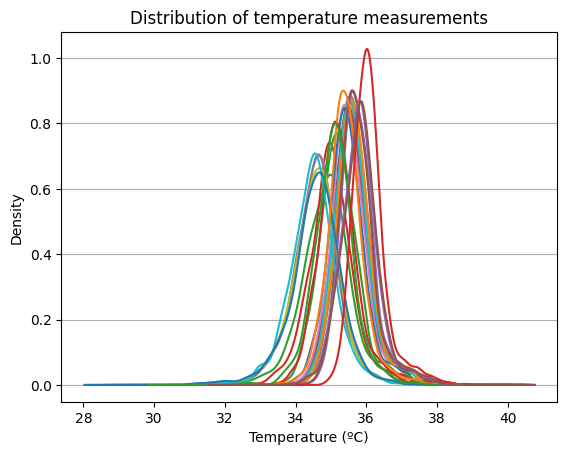

In [366]:
temps = [
  "Max1R13_1", "Max1L13_1", "aveAllR13_1", "aveAllL13_1", "T_RC1",
  "T_RC_Dry1", "T_RC_Wet1", "T_RC_Max1", "T_LC1", "T_LC_Dry1", "T_LC_Wet1",
  "T_LC_Max1", "RCC1", "LCC1", "canthiMax1", "canthi4Max1", "T_FHCC1", "T_FHRC1",
  "T_FHLC1", "T_FHBC1", "T_FHTC1", "T_FH_Max1", "T_FHC_Max1", "T_Max1", "T_OR1",
  "T_OR_Max1"
]

ax = plt.subplot()

for temp in temps:
  temperature_cleaned[temp].plot.kde(
    ax=ax
  )

ax.set_xlabel("Temperature (ºC)")
ax.set_title(f"Distribution of temperature measurements")
plt.grid(axis='y')
plt.savefig("1.3.1b.png", dpi=600, bbox_inches='tight')

Now, notice that these values span quite a large range, and, in particular, this range differs quite a bit from some of the other measurements like offset, distance, or the categorical encoding. Recall that gradient is computed using all of the features, so different features with different scales will contribute non-uniformly to the gradient vector, and hence the gradient descent process. To avoid this, let us try to scale each numerical feature to have mean 0 and a standard deviation of 1 (done in 1.2.1).

Let us now look at a correlation matrix/heatmap of the dataset.

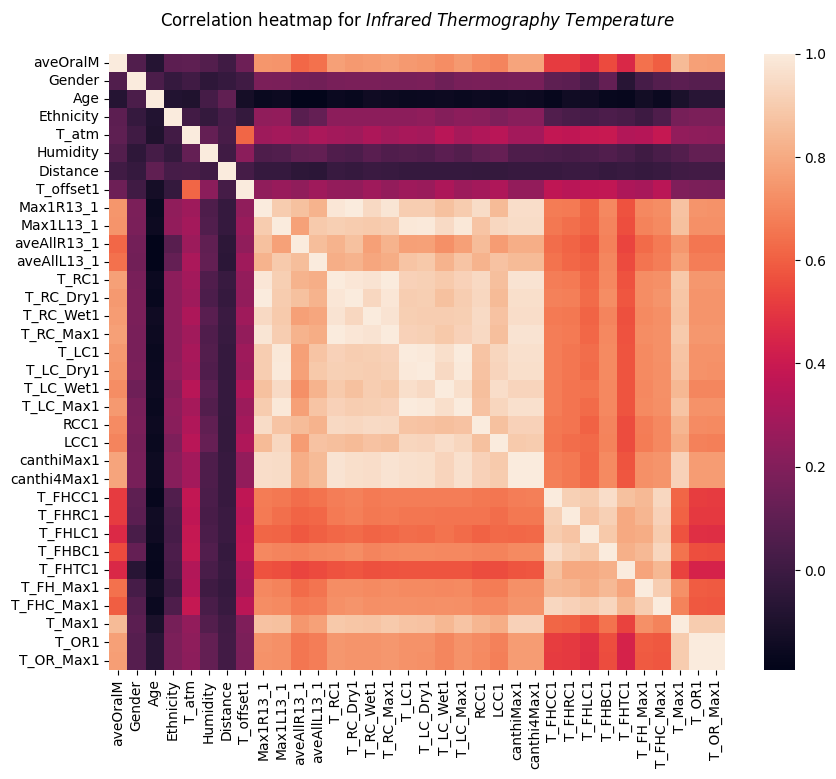

In [367]:
plt.figure(figsize=(10, 8))
sns.heatmap(temperature_cleaned.drop(columns=temp_features_scaled).corr(numeric_only=True), square=True)
plt.title(r"Correlation heatmap for $\it{Infrared\ Thermography\ Temperature}$", pad=20)
plt.savefig("1.3.1c.png", dpi=600, bbox_inches='tight')

If we focus on the `aveOralM` row/colums, we see that most of the other temperature measurements are well correlated with our target. In particular, the temperatures in the forehead region have a higher correlation. Interestingly, the "demographical information" (i.e., categorical features like gender or age) has little correlation with the target by itself. Perhaps this is due to the categorical/ordinal encoding that we have chosen

It would also be interesting to better see how environmental factors like the humidity or the ambient temperature are distributed to see if they may be confounding. The age and ethnicity of the subjects may also be interesting to examine to see the applicability of the data.

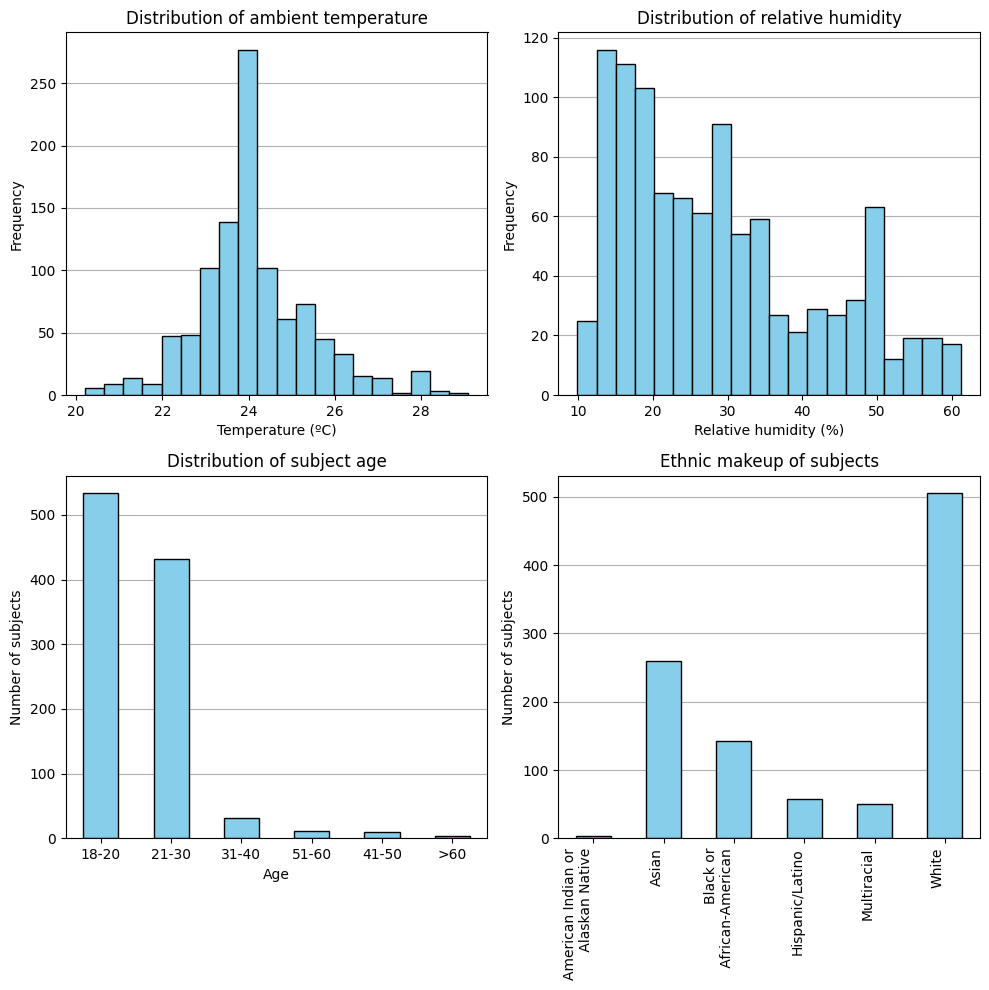

In [368]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

temperature_cleaned["T_atm"].plot.hist(
  bins=20, color='skyblue', edgecolor='black',
  xlabel="Temperature (ºC)", ylabel="Frequency",
  title="Distribution of ambient temperature",
  ax=axes[0][0]
)
axes[0][0].grid(axis='y')

temperature_cleaned["Humidity"].plot.hist(
  bins=20, color='skyblue', edgecolor='black',
  xlabel="Relative humidity (%)", ylabel="Frequency",
  title="Distribution of relative humidity",
  ax=axes[0][1]
)
axes[0][1].grid(axis='y')

temperature_cleaned["AgeCat"].value_counts().plot.bar(
  color='skyblue', edgecolor='black',
  xlabel="Age", ylabel="Number of subjects",
  title="Distribution of subject age", rot=0,
  ax=axes[1][0]
)
axes[1][0].grid(axis='y')

temperature_cleaned["EthnicityCat"].value_counts().sort_index().plot.bar(
  color='skyblue', edgecolor='black',
  xlabel="", ylabel="Number of subjects",
  title="Ethnic makeup of subjects",
  ax=axes[1][1]
)
axes[1][1].grid(axis='y')
axes[1][1].set_xticklabels(
  map(lambda x: x.replace("or", "or\n"), temperature_cleaned["EthnicityCat"].cat.categories),
  ha="right"
)

plt.tight_layout()
plt.savefig("1.3.1d.png", dpi=600, bbox_inches='tight')

It seems the room temperature is relatively consistent between the measurements, centering around 24º. As for the relative humidity, it seems this varies quite a bit, though with some concentration towards lower values. Surprisingly, it seems the dataset has a much younger subject population (&lt;30). Further, it also seems the ethnic makeup is not very well distributed, with a much higher proportion of white subjects. This threatens the applicability of our later results to other minorities.

#### 1.3.2 Basic statistics for _CDC Diabetes Health Indicators_
As suggested, let us examine how balanced the dataset is.

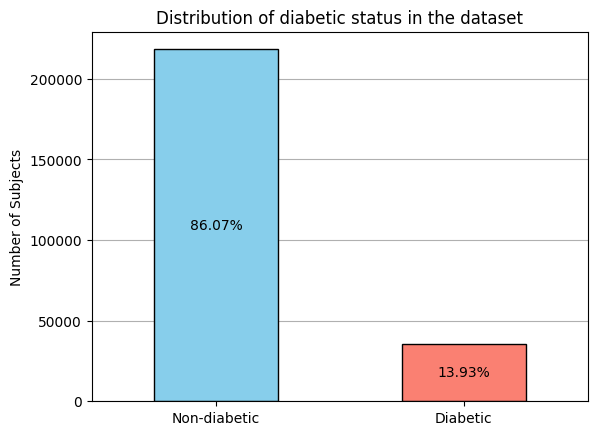

In [275]:
diabetes_cleaned["Diabetes_binary"].apply(lambda x: "Diabetic" if x else "Non-diabetic").value_counts().plot.bar(
  edgecolor='black', color=['skyblue', 'salmon'],
  rot=0, xlabel="", ylabel="Number of Subjects",
  title="Distribution of diabetic status in the dataset"
)
plt.grid(axis='y')

total = diabetes_cleaned["Diabetes_binary"].count()
for i in range(2):
  count = diabetes_cleaned["Diabetes_binary"].value_counts()[i]
  plt.text(i, count / 2, f"{count / total:.2%}", ha='center', va='center')

plt.savefig("1.3.2a.png", dpi=600, bbox_inches='tight')

We see there is a huge skew towards non-diabetic subjects. This may affect how well the model learns especially if the train-test split of the dataset causes further imbalance. As before, we can also examine the correlation matrix.

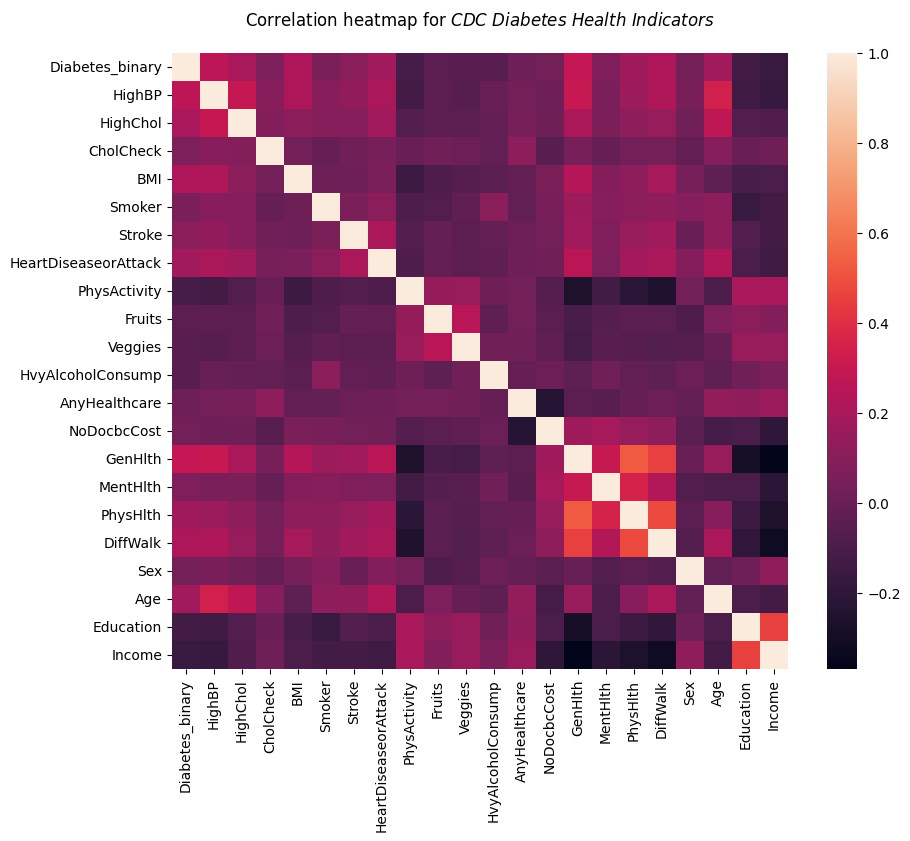

In [279]:
plt.figure(figsize=(10, 8))
sns.heatmap(diabetes_cleaned.corr(), square=True)
plt.title(r"Correlation heatmap for $\it{CDC\ Diabetes\ Health\ Indicators}$", pad=20)
plt.savefig("1.3.2b.png", dpi=600, bbox_inches='tight')

It seems there is generally little correlation with `Diabetes_binary` and any of the features. This might be since this dataset mostly has categorical/binary features. Interestingly, it seems that `GenHealth`, a subjective response by the subject, is the most correlated!

To get a better understanding of the data, we can also look at some distributions of key demographics like age, BMI, and high blood pressure/cholesterol measurements.

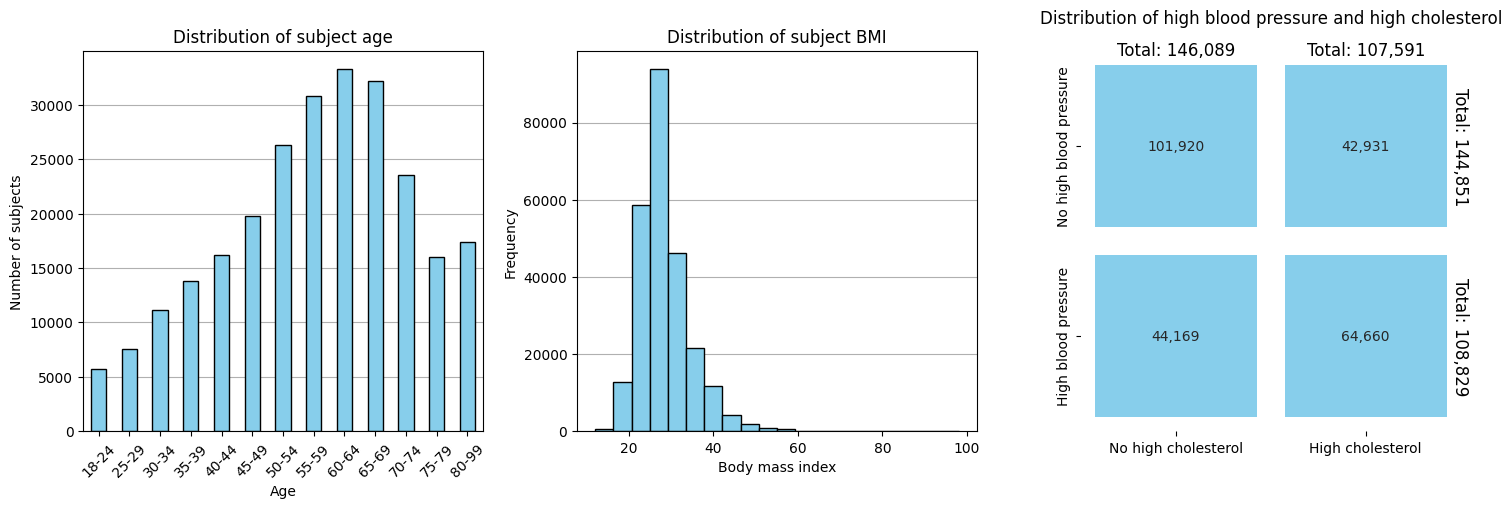

In [280]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

diabetes_cleaned["Age"].value_counts().sort_index().plot.bar(
  color='skyblue', edgecolor='black',
  xlabel="Age", ylabel="Number of subjects",
  title="Distribution of subject age", rot=45,
  ax=axes[0]
)
axes[0].grid(axis='y')
axes[0].set_xticklabels([
  '18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54',
  '55-59', '60-64', '65-69', '70-74', '75-79', '80-99'
])


diabetes_cleaned["BMI"].plot.hist(
  bins=20, color='skyblue', edgecolor='black',
  xlabel="Body mass index", ylabel="Frequency",
  title="Distribution of subject BMI",
  ax=axes[1]
)
axes[1].grid(axis='y')

cross = pd.crosstab(diabetes_cleaned['HighBP'], diabetes_cleaned['HighChol'])

rows = cross.sum(axis=1)
cols = cross.sum(axis=0)

sns.heatmap(
  cross, annot=True, fmt=',d', cbar=False, square=True,
  linewidths=20, ax=axes[2], vmin=1, vmax=1, cmap=['skyblue'],
  xticklabels=["No high cholesterol", "High cholesterol"],
  yticklabels=["No high blood pressure", "High blood pressure"]
)

for i in range(2):
    axes[2].text(1.95, i + 0.5, f'Total: {rows[i]:,}', va='center', fontsize=12, color='black', rotation=-90)
    axes[2].text(i + 0.5, 0.02, f'Total: {cols[i]:,}', ha='center', fontsize=12, color='black')

axes[2].set_title('Distribution of high blood pressure and high cholesterol', pad=20)
axes[2].set_xlabel("")
axes[2].set_ylabel("")

plt.tight_layout()
plt.savefig("1.3.2c.png", dpi=600, bbox_inches='tight')

Here, we can see that most of the subjects are a bit older, around the 50-70 range. The body mass index tends to be concentrated towards the average. As expected, the dataset is mostly distributed between subjects that either both have high blood pressure and cholesterol or those who do not (since these conditions are linked).

## Task 2: Implement the models
### 2.1 Implementing linear regression
The following Python class contains our implementation for linear regression. The implementation is largely derived from the sample code presented in lecture notebooks. We have added a `cost` method to evaluate performance which will be used in later analysis. It is based on the form presented in lectures:

$$J(w)=\frac{1}{N}\sum_{n=1}^N\frac{1}{2}\left(y^{(n)}-\hat y^{(n)}\right)^2=\frac{1}{N}\sum_{n=1}^N\frac{1}{2}\left(y^{(n)}-w^\top x^{(n)}\right)^2$$

In [442]:
class LinearRegression:
  def __init__(self, bias: bool = True):
    self.bias = bias
    self.weights = None

  def fit(self, x: np.ndarray, y: np.ndarray):
    if x.ndim == 1:
      x = x[:, None]

    if self.bias:
      x = np.column_stack([x, np.ones(x.shape[0])])

    self.weights = np.linalg.inv(x.T @ x) @ x.T @ y

  def predict(self, x: np.ndarray):
    if self.bias:
      x = np.column_stack([x, np.ones(x.shape[0])])

    return x @ self.weights

  @staticmethod
  def cost(yh: np.ndarray, y: np.ndarray):
    return 0.5 * np.mean((yh - y) ** 2)


### 2.2 Implementing logistic regression
The following Python class contains our implementation for logistic regression. Again, the implementation is largely derived from the sample code presented in lecture notebooks and we have added a `cost` method based on the following definition from lectures:

$$
\begin{align*}
J(w) &= \frac{1}{N}\sum_{n=1}^N\left[-y^{(n)}\log(\hat y^{(n)})-(1-y^{(n)})\log(1-\hat y^{(n)})\right] \\
&= \frac{1}{N}\sum_{n=1}^N\left[y^{(n)}\log(1+e^{-w^\top x^{(n)}})+(1-y^{(n)})\log(1+e^{w^\top x^{(n)}})\right]
\end{align*}
$$

In [668]:
class LogisticRegression:
  def __init__(self, bias: bool = True, alpha: float = 0.01, eps: float = 1e-6, itercap: int = 1e4):
    self.bias = bias
    self.alpha = alpha
    self.eps = eps
    self.itercap = itercap

    self.weights = None

  @staticmethod
  def sigmoid(z: np.ndarray):
    return 1 / (1 + np.exp(-z))

  def gradient(self, x: np.ndarray, y: np.ndarray):
    return np.dot(x.T, LogisticRegression.sigmoid(np.dot(x, self.weights)) - y) / x.shape[0]

  def fit(self, x: np.ndarray, y: np.ndarray):
    if x.ndim == 1:
      x = x[:, None]

    N, D = x.shape
    x_orig = x

    if self.bias:
      x = np.column_stack([x, np.ones(N)])
      D += 1

    self.weights = np.zeros(D)
    gradient = np.inf
    prev = np.inf
    curr = LogisticRegression.cost(self.predict(x_orig), y)
    t = 0

    while abs(prev - curr) > self.eps and t < self.itercap:
      prev = curr

      gradient = self.gradient(x, y)
      self.weights -= self.alpha * gradient
      curr = LogisticRegression.cost(self.predict(x_orig), y)

      t += 1

    return (t, gradient)

  def predict(self, x: np.ndarray):
    if self.bias:
      x = np.column_stack([x, np.ones(x.shape[0])])

    return LogisticRegression.sigmoid(np.dot(x, self.weights))

  @staticmethod
  def cost(yh: np.ndarray, y: np.ndarray):
    # Avoid log(0) and log(1 + (-1))
    yh[yh == 0] = 1e-10
    yh[yh == 1] = 1 - 1e-10

    return -np.mean(y * np.log(yh) + (1 - y) * np.log1p(-yh))


### 2.3 Implementing mini-batch stochastic gradient descent
#### 2.3.1 SGD for linear regression

The following Python class contains our implementation for mini-batch stochastic gradient descent for linear regression.

In [371]:
class LinearRegressionSGD:
  def __init__(self, bias: bool = True, alpha: float = 0.01, eps: float = 1e-8, itercap: int = 1e5, b: int = 32, hist = False):
    self.bias = bias
    self.alpha = alpha
    self.eps = eps
    self.itercap = itercap
    self.b = b
    self.hist = hist
    self.costs = []

    self.weights = None

  def gradient(self, x: np.ndarray, y: np.ndarray):
    return np.dot(x.T, x @ self.weights - y) / x.shape[0]

  def fit(self, x: np.ndarray, y: np.ndarray):
    if x.ndim == 1:
      x = x[:, None]

    N, D = x.shape
    x_orig = x

    if self.bias:
      x = np.column_stack([x, np.ones(N)])
      D += 1

    self.weights = np.zeros(D)
    gradient = np.inf
    prev = np.inf
    curr = LinearRegression.cost(self.predict(x_orig), y)
    batches = []
    t = 0
    batch = 0

    while abs(prev - curr) > self.eps and t < self.itercap:
      if batch == 0:
        idxs = np.random.permutation(N)
        x_shuffled = x[idxs]
        y_shuffled = y[idxs]
        batches = [(x_shuffled[i:i + self.b], y_shuffled[i:i + self.b]) for i in range(0, N, self.b)]

      prev = curr

      x_batch, y_batch = batches[batch]
      batch = (batch + 1) % len(batches)

      gradient = self.gradient(x_batch, y_batch)
      self.weights -= self.alpha * gradient
      curr = LinearRegression.cost(self.predict(x_orig), y)

      if self.hist:
        self.costs.append(curr)

      t += 1

    return (t, gradient)

  def predict(self, x: np.ndarray):
    if self.bias:
      x = np.column_stack([x, np.ones(x.shape[0])])

    return x @ self.weights


#### 2.3.2 SGD for logistic regression

The following Python class contains our implementation for mini-batch stochastic gradient descent for logistic regression.

In [372]:
class LogisticRegressionSGD:
  def __init__(self, bias: bool = True, alpha: float = 0.01, eps: float = 1e-6, itercap: int = 1e4, b: int = 32, hist = False):
    self.bias = bias
    self.alpha = alpha
    self.eps = eps
    self.itercap = itercap
    self.b = b
    self.hist = hist
    self.costs = []

    self.weights = None

  def gradient(self, x: np.ndarray, y: np.ndarray):
    return np.dot(x.T, LogisticRegression.sigmoid(np.dot(x, self.weights)) - y) / x.shape[0]

  def fit(self, x: np.ndarray, y: np.ndarray):
    if x.ndim == 1:
      x = x[:, None]

    N, D = x.shape
    x_orig = x

    if self.bias:
      x = np.column_stack([x, np.ones(N)])
      D += 1

    self.weights = np.zeros(D)
    gradient = np.inf
    prev = np.inf
    curr = LogisticRegression.cost(self.predict(x_orig), y)
    batches = []
    t = 0
    batch = 0

    while abs(prev - curr) > self.eps and t < self.itercap:
      if batch == 0:
        idxs = np.random.permutation(N)
        x_shuffled = x[idxs]
        y_shuffled = y[idxs]
        batches = [(x_shuffled[i:i + self.b], y_shuffled[i:i + self.b]) for i in range(0, N, self.b)]

      prev = curr

      x_batch, y_batch = batches[batch]
      batch = (batch + 1) % len(batches)

      gradient = self.gradient(x_batch, y_batch)
      self.weights -= self.alpha * gradient
      curr = LogisticRegression.cost(self.predict(x_orig), y)

      if self.hist:
        self.costs.append(curr)

      t += 1

    return (t, gradient)

  def predict(self, x: np.ndarray):
    if self.bias:
      x = np.column_stack([x, np.ones(x.shape[0])])

    return LogisticRegression.sigmoid(np.dot(x, self.weights))


## Task 3: Run experiments

To help us out, let's define a helper function for test-training splits.

In [373]:
def split(df, train_split: float):
  train = df.sample(frac=train_split)
  test = df.drop(train.index)
  return (train, test)

### 3.1. Performance of models
#### 3.1.1 Linear regression

Let us compute the analytic linear regression solution and evaluate the performance as follows.

In [471]:
temperature_train, temperature_test = split(temperature_cleaned, 0.8)

x_train = temperature_train[temp_features].to_numpy()
y_train = temperature_train["aveOralM"].to_numpy()

x_test = temperature_test[temp_features].to_numpy()
y_test = temperature_test["aveOralM"].to_numpy()

linReg = LinearRegression()
linReg.fit(x_train, y_train)

yh_train = linReg.predict(x_train)
yh_test = linReg.predict(x_test)

cost_train = LinearRegression.cost(yh_train, y_train)
cost_test = LinearRegression.cost(yh_test, y_test)

print(f"J(w) for train set: {cost_train:.5f}")
print(f"J(w) for test set: {cost_test:.5f}")

J(w) for train set: 0.03052
J(w) for test set: 0.03568


#### 3.1.2 Logistic regression

Let us compute the logistic regression solution with full batching and evaluate the performance as follows.

In [496]:
diabetes_train, diabetes_test = split(diabetes_cleaned, 0.8)

x_train = diabetes_train.drop(columns=["Diabetes_binary"]).to_numpy()
y_train = diabetes_train["Diabetes_binary"].to_numpy()

x_test = diabetes_test.drop(columns=["Diabetes_binary"]).to_numpy()
y_test = diabetes_test["Diabetes_binary"].to_numpy()

logReg = LogisticRegression()
t, _ = logReg.fit(x_train, y_train)

yh_train = logReg.predict(x_train)
yh_test = logReg.predict(x_test)

print(f"Converged after {t} iterations.")

Converged after 6689 iterations.


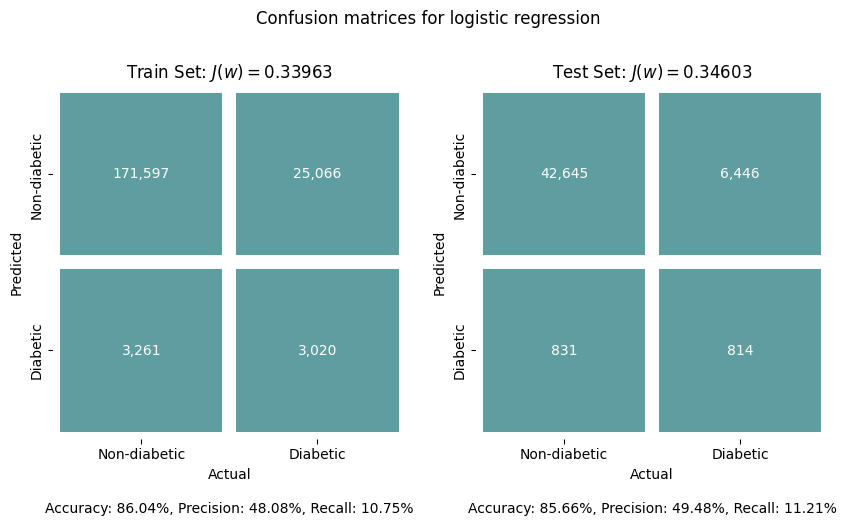

In [497]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, (group, yh, y) in enumerate([("Train", yh_train, y_train), ("Test", yh_test, y_test)]):
  cost = LogisticRegression.cost(yh, y)
  yh = np.round(yh)
  confusion = pd.crosstab(pd.Series(yh, name="Predicted", dtype=int), pd.Series(y, name="Actual", dtype=int))

  sns.heatmap(
    confusion, annot=True, fmt=',d', cbar=False, square=True,
    linewidths=10, ax=axes[i], vmin=1, vmax=1, cmap=['cadetblue'],
    xticklabels=["Non-diabetic", "Diabetic"],
    yticklabels=["Non-diabetic", "Diabetic"]
  )

  total = confusion.values.sum()
  accuracy = (confusion.loc[0].loc[0] + confusion.loc[1].loc[1]) / total
  precision = confusion.loc[1].loc[1] / confusion.loc[1].sum()
  recall = confusion.loc[1].loc[1] / (confusion.loc[1][1] + confusion.loc[0][1])

  axes[i].text(1.0, 2.4, f'Accuracy: {accuracy:.2%}, Precision: {precision:.2%}, Recall: {recall:.2%}', va='center', ha='center', fontsize=10, color='black')

  axes[i].set_title(f'{group} Set: $J(w)={cost:.5f}$')
  axes[i].set_xlabel("Actual")
  axes[i].set_ylabel("Predicted")

  plt.suptitle("Confusion matrices for logistic regression", y=1)
  plt.savefig("3.1.2.png", dpi=600, bbox_inches='tight')

### 3.2 Model weights derived from fitting
#### 3.2.1 Model weights for _Infrared Thermography Temperature_

Let us combine the derived model weights with the column titles to understand how features affect the target.

In [472]:
pd.DataFrame(
  linReg.weights.tolist(),
  index=list(map(lambda x: x.removesuffix("_Scaled"), temp_features)) + ["Bias"],
  columns=["Weight"]
).sort_values("Weight", ascending=False).transpose()

,Bias,T_RC_Max1,canthi4Max1,T_LC1,T_Max1,T_RC_Dry1,LCC1,T_FHC_Max1,T_FH_Max1,T_FHBC1,T_OR_Max1,T_RC_Wet1,RCC1,T_offset1,T_OR1,T_FHTC1,Distance,Age,T_FHRC1,Humidity,aveAllR13_1,T_LC_Dry1,Ethnicity,Gender,aveAllL13_1,T_LC_Wet1,T_LC_Max1,T_atm,T_FHLC1,T_FHCC1,Max1L13_1,Max1R13_1,T_RC1,canthiMax1
Weight,37.097477,0.470134,0.409641,0.316271,0.230363,0.165213,0.109811,0.077806,0.067215,0.06664,0.064407,0.041518,0.033014,0.023185,0.022399,0.014329,0.007517,0.0045,0.001542,0.001431,-0.00752,-0.016845,-0.017161,-0.046026,-0.046949,-0.056156,-0.077948,-0.091618,-0.098012,-0.108514,-0.156526,-0.214273,-0.397585,-0.444833


It seems that the most "influential" features on the target are the maximum temperature value in the extended canthi area, temperature around the left/right canthus, and maximum temperature over the whole face.

The least "influential" are, unsurprisingly, the demographic features like age, gender, or ethnicity. Environmental measurements like the relative humidity or the room's temperature also have little effect (although the effect of `T_atm` is not relatively neglible). Also important to note that the distance feature seems to have minimal influence as well.

#### 3.2.2 Model weights for _CDC Diabetes Health Indicators_

Let us again combine the derived model weights with the column titles to understand how features affect the target. Before this however, recall that, by the relationship between the sigmoid and logit functions, the model weights should be interpreted via exponentation, so let us apply this.

In [498]:
pd.DataFrame(
  np.exp(logReg.weights).tolist(),
  index=list(diabetes_cleaned.drop(columns=["Diabetes_binary"]).columns) + ["Bias"],
  columns=["Weight"]
).sort_values("Weight", ascending=False).transpose()

,HighBP,HighChol,HeartDiseaseorAttack,GenHlth,DiffWalk,Sex,Stroke,Age,BMI,PhysHlth,MentHlth,Income,Fruits,NoDocbcCost,Smoker,Veggies,HvyAlcoholConsump,PhysActivity,AnyHealthcare,CholCheck,Education,Bias
Weight,2.006715,1.681291,1.352643,1.264681,1.237641,1.1297,1.09107,1.022379,1.018521,1.002202,0.990262,0.903596,0.868513,0.854801,0.850594,0.821122,0.818115,0.761367,0.755583,0.727936,0.710154,0.561121


It seems that having high blood pressure contributes the most to the odds of having diabetes, with high cholesterol and heart problems being the next closest. On the other hand, most of the demographic information (besides sex, age, stroke presence, BMI, and physical health) seems to not have much effect.

### 3.3 Effect of test-training split on model performance
#### 3.3.1 Performance of linear regression

Let us run our model with different training-test splits to see how it alters the performance. We will run 100 iterations with each split to axxount for deviations due to randomness.

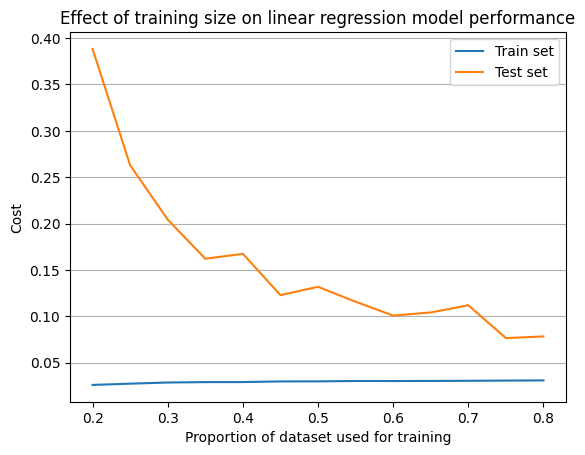

In [474]:
train_costs = []
test_costs = []

train_splits = np.arange(0.2, 0.8, 0.05)

for train_split in train_splits:
  train_cost = 0
  test_cost = 0

  for _ in range(100):
    temperature_train, temperature_test = split(temperature_cleaned, train_split)

    x_train = temperature_train[temp_features].to_numpy()
    y_train = temperature_train["aveOralM"].to_numpy()

    x_test = temperature_test[temp_features].to_numpy()
    y_test = temperature_test["aveOralM"].to_numpy()

    linReg = LinearRegression()
    linReg.fit(x_train, y_train)

    yh_train = linReg.predict(x_train)
    yh_test = linReg.predict(x_test)

    train_cost += LinearRegression.cost(yh_train, y_train)
    test_cost += LinearRegression.cost(yh_test, y_test)

  train_costs.append(train_cost / 100)
  test_costs.append(test_cost / 100)

plt.plot(train_splits, train_costs, label="Train set")
plt.plot(train_splits, test_costs, label="Test set")
plt.title("Effect of training size on linear regression model performance")
plt.xlabel("Proportion of dataset used for training")
plt.ylabel("Cost")
plt.grid(axis='y')
plt.legend()
plt.savefig("3.3.1.png", dpi=600, bbox_inches='tight')

It seems the performance of the training set remains quite consistent and high (i.e., low cost). As expected, the performance of the test set increases as the training set's size increases (of course with some noise due to randomness). This is of course due to the fact that the model has a greater sample of the data, hence allowing it to "make better predictions". And, compared to the training set, the performance of the test set is typically a bit worse, which is expected since, to the model, the test dataset is always "new" data, so it hasn't been taken into account when performing the regression.

#### 3.3.2 Performance of logistic regression

Let us run our model with different training-test splits to see how it alters the performance.

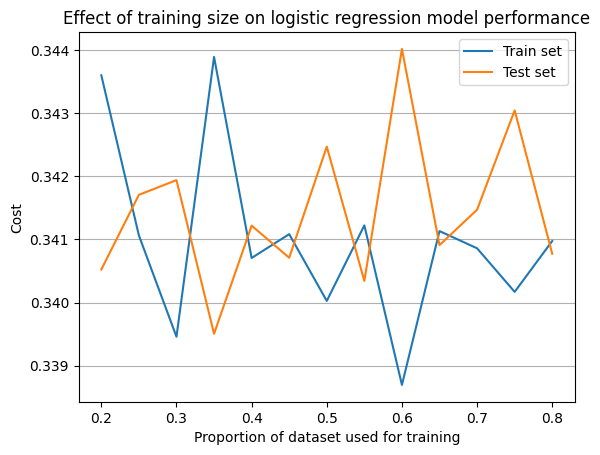

In [364]:
train_costs = []
test_costs = []

train_splits = np.arange(0.2, 0.8, 0.05)

for train_split in train_splits:
  diabetes_train, diabetes_test = split(diabetes_cleaned, train_split)

  x_train = diabetes_train.drop(columns=["Diabetes_binary"]).to_numpy()
  y_train = diabetes_train["Diabetes_binary"].to_numpy()

  x_test = diabetes_test.drop(columns=["Diabetes_binary"]).to_numpy()
  y_test = diabetes_test["Diabetes_binary"].to_numpy()

  logReg = LogisticRegression()
  logReg.fit(x_train, y_train)

  yh_train = logReg.predict(x_train)
  yh_test = logReg.predict(x_test)

  train_costs.append(LogisticRegression.cost(yh_train, y_train))
  test_costs.append(LogisticRegression.cost(yh_test, y_test))

plt.plot(train_splits, train_costs, label="Train set")
plt.plot(train_splits, test_costs, label="Test set")
plt.title("Effect of training size on logistic regression model performance")
plt.xlabel("Proportion of dataset used for training")
plt.ylabel("Cost")
plt.grid(axis='y')
plt.legend()

plt.savefig("3.3.2.png", dpi=600, bbox_inches='tight')

Apart from noise due to randomness, it seems that there is little effect on the performance of the model on both subsets of the dataset as the split changes. This may be related to our earlier observation that, due to the imbalanced nature of the dataset, the model may not have enough information to discern the class boundaries and may just always be classifying the whole dataset (most of the time) as non-diabetic.

### 3.4 Effect of mini-batch size on SGD model performance
### 3.4.1 Performance for linear regression

Let us plot the convergence speed (number of iterations) and the performance as a function of the mini-batch size used and compare it with the performance of a fully batched gradient descent (at the furthest right).

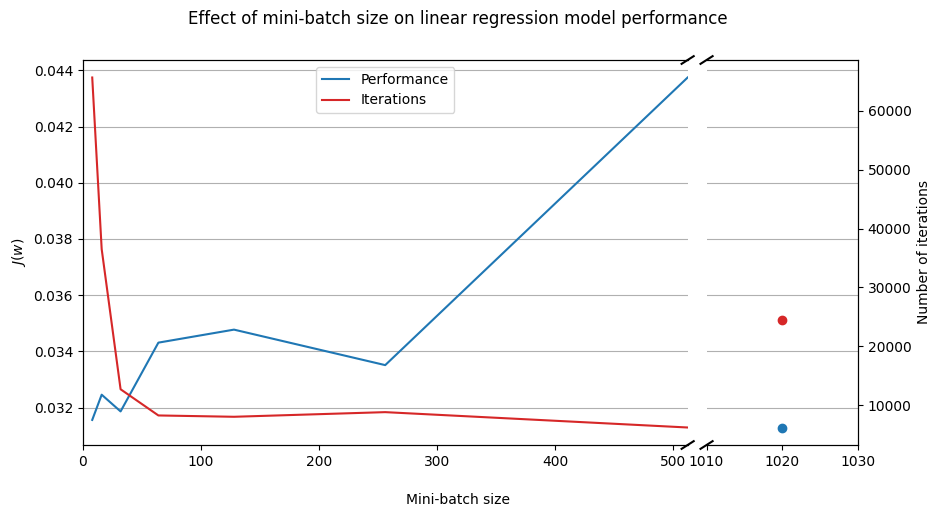

In [432]:
x = temperature_cleaned[temp_features].to_numpy()
y = temperature_cleaned["aveOralM"].to_numpy()

sizes = [8, 16, 32, 64, 128, 256, 512, len(temperature_cleaned)]
costs = []
iterations = []

for b in sizes:
  linRegSGD = LinearRegressionSGD(b=b)
  t, _ = linRegSGD.fit(x, y)

  yh = linRegSGD.predict(x)

  costs.append(LinearRegression.cost(yh, y))
  iterations.append(t)

fig, (ax_close, ax_far) = plt.subplots(1, 2, sharey=True, gridspec_kw={'width_ratios': [4, 1]}, figsize=(10, 5))
ax_close_perf = ax_close.twinx()
ax_far_perf = ax_far.twinx()

ax_close_perf.sharey(ax_far_perf)

l1 = ax_close.plot(sizes[:-1], costs[:-1], label="Performance", color='tab:blue')
l2 = ax_close_perf.plot(sizes[:-1], iterations[:-1], label="Iterations", color='tab:red')
ax_far.plot(sizes[-1], costs[-1], 'o', color='tab:blue')
ax_far_perf.plot(sizes[-1], iterations[-1], 'o', color='tab:red')

l = l1 + l2

ax_close.legend(l, [l.get_label() for l in l], loc='upper center')
ax_close.grid(axis='y')
ax_far.grid(axis='y')

ax_close.set_xlim(0, 512)
ax_far.set_xlim(sizes[-1] - 10, sizes[-1] + 10)
ax_close.spines['right'].set_visible(False)
ax_close_perf.spines['right'].set_visible(False)
ax_far.spines['left'].set_visible(False)
ax_far_perf.spines['left'].set_visible(False)

ax_close_perf.tick_params(labelright=False, right=False)
ax_far.tick_params(labelleft=False, left=False)

fig.subplots_adjust(wspace=0.05)

d = 0.01
kwargs = dict(transform=ax_close.transAxes, color='k', clip_on=False)
ax_close.plot((1-d, 1+d), (-d, +d), **kwargs)
ax_close.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

kwargs.update(transform=ax_far.transAxes)
ax_far.plot((-4*d, 4*d), (1-d, 1+d), **kwargs)
ax_far.plot((-4*d, 4*d), (-d, +d), **kwargs)

plt.suptitle("Effect of mini-batch size on linear regression model performance")
ax_close.set_ylabel("$J(w)$")
ax_far_perf.set_ylabel("Number of iterations")
plt.figtext(0.5, 0, "Mini-batch size", ha='center', va='center')
plt.savefig("3.4.1.png", dpi=600, bbox_inches='tight')

An interesting pattern we see is that, typically, the more iterations it takes for a particular mini-batch size to converge, the better the performance. 

However, we also note that there is a lot of noise in 4-256 batch size region. For example, when the batch size is 4, we see that it takes a lot of iterations to converge, but it converges well (i.e., high performance). This can likely be attributed to the fact that the smaller batch size allows the descent to "jump around" a bit and perhaps avoid local minima. 

For some of the larger batch sizes, it may be the case that the batch is too big to jump around and avoid local optima, but not big enough to provide a proper gradient approximation. We see that the fully batched gradient descent performs the best, but also takes a few more iterations to converge, likely since there is less "jumping around". 

Based on these observations and our graph, it seems that a batch size of about 32 offer the best compromise between convergence speed and performance time.

#### 3.4.2 Performance for logistic regression

Again, let us plot the convergence speed (number of iterations) and the performance as a function of the mini-batch size used and compare it with the performance of a fully batched gradient descent (at the furthest right).

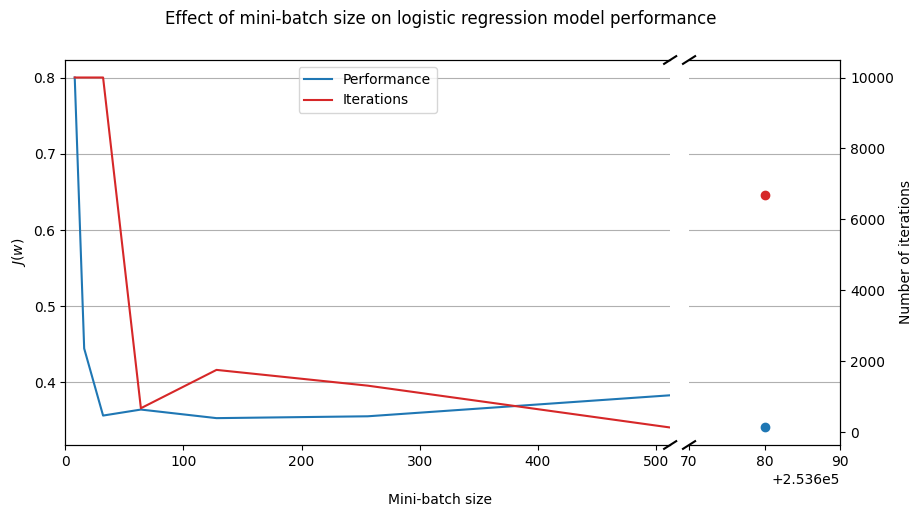

In [109]:
x = diabetes_cleaned.drop(columns=["Diabetes_binary"]).to_numpy()
y = diabetes_cleaned["Diabetes_binary"].to_numpy()

sizes = [8, 16, 32, 64, 128, 256, 512, len(diabetes_cleaned)]
costs = []
iterations = []

for b in sizes:
  logRegSGD = LogisticRegressionSGD(b=b)
  t, _ = logRegSGD.fit(x, y)

  yh = logRegSGD.predict(x)

  costs.append(LogisticRegression.cost(yh, y))
  iterations.append(t)


fig, (ax_close, ax_far) = plt.subplots(1, 2, sharey=True, gridspec_kw={'width_ratios': [4, 1]}, figsize=(10, 5))
ax_close_perf = ax_close.twinx()
ax_far_perf = ax_far.twinx()

ax_close_perf.sharey(ax_far_perf)

l1 = ax_close.plot(sizes[:-1], costs[:-1], label="Performance", color='tab:blue')
l2 = ax_close_perf.plot(sizes[:-1], iterations[:-1], label="Iterations", color='tab:red')
ax_far.plot(sizes[-1], costs[-1], 'o', color='tab:blue')
ax_far_perf.plot(sizes[-1], iterations[-1], 'o', color='tab:red')

l = l1 + l2

ax_close.legend(l, [l.get_label() for l in l], loc='upper center')
ax_close.grid(axis='y')
ax_far.grid(axis='y')

ax_close.set_xlim(0, 512)
ax_far.set_xlim(sizes[-1] - 10, sizes[-1] + 10)
ax_close.spines['right'].set_visible(False)
ax_close_perf.spines['right'].set_visible(False)
ax_far.spines['left'].set_visible(False)
ax_far_perf.spines['left'].set_visible(False)

ax_close_perf.tick_params(labelright=False, right=False)
ax_far.tick_params(labelleft=False, left=False)

fig.subplots_adjust(wspace=0.05)

d = 0.01
kwargs = dict(transform=ax_close.transAxes, color='k', clip_on=False)
ax_close.plot((1-d, 1+d), (-d, +d), **kwargs)
ax_close.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

kwargs.update(transform=ax_far.transAxes)
ax_far.plot((-4*d, 4*d), (1-d, 1+d), **kwargs)
ax_far.plot((-4*d, 4*d), (-d, +d), **kwargs)

plt.suptitle("Effect of mini-batch size on logistic regression model performance")
ax_close.set_ylabel("$J(w)$")
ax_far_perf.set_ylabel("Number of iterations")
plt.figtext(0.5, 0, "Mini-batch size", ha='center', va='center')
plt.savefig("3.4.2.png", dpi=600, bbox_inches='tight')


Interestingly, the results are a bit different for logistic regression, but they may not have to do with the method itself but rather the size of the dataset. We see that like before, the smaller batch sizes take a lot of iterations to converge (likely did not converge for a batch size of 8). However, as we go past a batch size of 64, we see that the iterations drop drastically and, more importantly, the performance improves as well. 

This is likely due to the fact that these batch sizes are large enough to generate appropriate approximations for the gradient while also small enough to jump around the cost space and avoid local optima. Given these observations, a batch size of 64-256 looks like the best configuration.

### 3.5 Effect of learning rate on model performance
#### 3.5.1 Performance of linear regression

Let us plot the training curves and see how the stochastic gradient descent is affected for linear regression.

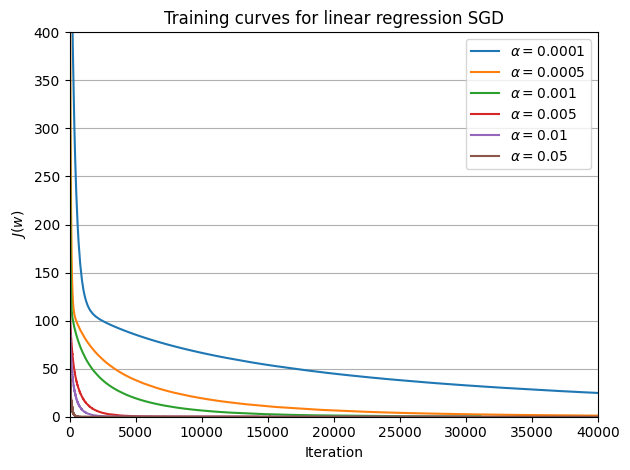

In [726]:
cost_by_iterations = { 0.0001: [], 0.0005: [], 0.001: [], 0.005: [], 0.01: [], 0.05: [] }

temperature_train, temperature_test = split(temperature_cleaned, 0.8)

x_train = temperature_train[temp_features].to_numpy()
y_train = temperature_train["aveOralM"].to_numpy()

x_test = temperature_test[temp_features].to_numpy()
y_test = temperature_test["aveOralM"].to_numpy()

for alpha in cost_by_iterations:
  linRegSGD = LinearRegressionSGD(alpha=alpha, hist=True)
  linRegSGD.fit(x_train, y_train)

  cost_by_iterations[alpha] = linRegSGD.costs


for alpha, costs in cost_by_iterations.items():
  plt.plot(costs, label=f"$\\alpha={alpha}$")

plt.grid(axis='y')
plt.ylim(0, 400)
plt.xlim(0, 4e4)
plt.legend()

plt.title("Training curves for linear regression SGD")
plt.xlabel("Iteration")
plt.ylabel("$J(w)$")

plt.tight_layout()
plt.savefig("3.5.1.png", dpi=600, bbox_inches='tight')

The training curves show that although all the models tend towards the optimal, those with larger values tend to do so faster. This faster rate allows the models to reach the optimal quicker, without reaching the maximum iteration threshold. 

Something else that is interesting to note (not graphed) is that as we increase the learning rate beyond 0.05, the model actually starts to diverge, leading to an exponential increase in the cost.

#### 3.5.2 Performance of logistic regression

Let us plot the training curves and see how the stochastic gradient descent is affected for logistic regression.

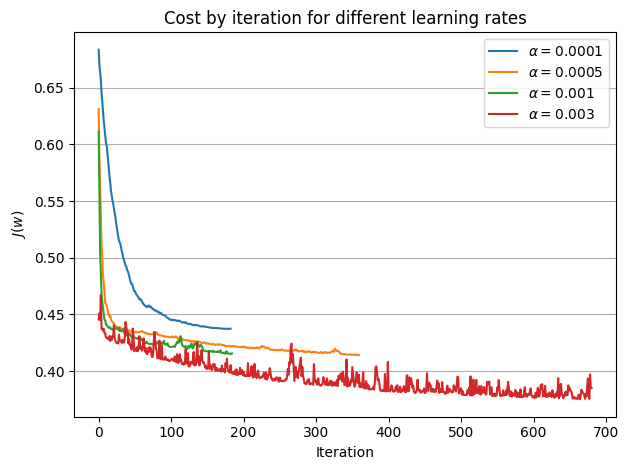

In [727]:
cost_by_iterations = { 0.0001: [], 0.0005: [], 0.001: [], 0.003: [] }

diabetes_train, diabetes_test = split(diabetes_cleaned, 0.8)

x_train = diabetes_train.drop(columns=["Diabetes_binary"]).to_numpy()
y_train = diabetes_train["Diabetes_binary"].to_numpy()

x_test = diabetes_test.drop(columns=["Diabetes_binary"]).to_numpy()
y_test = diabetes_test["Diabetes_binary"].to_numpy()

for alpha in cost_by_iterations:
  logRegSGD = LogisticRegressionSGD(alpha=alpha, hist=True)
  logRegSGD.fit(x_train, y_train)

  cost_by_iterations[alpha] = logRegSGD.costs


for alpha, costs in cost_by_iterations.items():
  plt.plot(costs, label=f"$\\alpha={alpha}$")

plt.grid(axis='y')
plt.legend()

plt.title("Cost by iteration for different learning rates")
plt.xlabel("Iteration")
plt.ylabel("$J(w)$")

plt.tight_layout()
plt.savefig("3.5.2.png", dpi=600, bbox_inches='tight')

As before, we see that increasing the learning rate leads to a faster convergence sequence. We can see that with a learning rate of 0.003, the model starts to become a bit erratic, but still tends towards convergence.

### 3.6 Comparing analytical and SGD linear regression implementations

To evaluate the performance of both models, lets utilize the optimal parameters we found in earlier parts ($\alpha=0.05$, mini-batch size = 32) and do 100 runs of both models, with 70-30 training-test splits. We will evaluate the performance of the models on the testing split of course.

Analytical method: 88
Stochastic gradient descent: 12


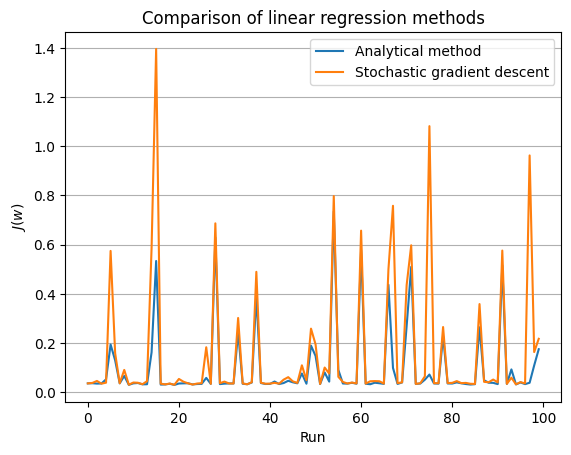

In [475]:
analytic_costs = []
sgd_costs = []

for _ in range(100):
  temperature_train, temperature_test = split(temperature_cleaned, 0.7)

  x_train = temperature_train[temp_features].to_numpy()
  y_train = temperature_train["aveOralM"].to_numpy()

  x_test = temperature_test[temp_features].to_numpy()
  y_test = temperature_test["aveOralM"].to_numpy()

  linReg = LinearRegression()
  linRegSGD = LinearRegressionSGD(alpha=0.05, b=32)

  linReg.fit(x_train, y_train)
  linRegSGD.fit(x_train, y_train)

  yh_analytic = linReg.predict(x_test)
  yh_sgd = linRegSGD.predict(x_test)

  analytic_costs.append(LinearRegression.cost(yh_analytic, y_test))
  sgd_costs.append(LinearRegression.cost(yh_sgd, y_test))

plt.plot(analytic_costs, label="Analytical method")
plt.plot(sgd_costs, label="Stochastic gradient descent")
plt.title("Comparison of linear regression methods")
plt.xlabel("Run")
plt.ylabel("$J(w)$")
plt.legend()
plt.grid(axis='y')
plt.savefig("3.6.png", dpi=600, bbox_inches='tight')

print("Analytical method:", sum(analytic_costs[i] < sgd_costs[i] for i in range(100)))
print("Stochastic gradient descent:", sum(sgd_costs[i] < analytic_costs[i] for i in range(100)))

## 4: Going beyond

A common thread throughout our exploration and results has been the imbalanced nature of the _CDC Diabetes Health Indicators_. Let us see how some of our results change when we re-sample the dataset. We will use `imblearn` to test various different methods of re-sampling including both over-sampling (random selection, SMOTE, and ADASYN) and under-sampling (randomized selection and near miss).

In [720]:
ornd = RandomOverSampler()
urnd = RandomUnderSampler()
sm = SMOTE(k_neighbors=10)
ad = ADASYN(n_neighbors=10)
nm = NearMiss(version=1, n_neighbors=10)

features = diabetes_cleaned.drop(columns=["Diabetes_binary"])
target = diabetes_cleaned["Diabetes_binary"]

diabetes_ornd = pd.concat([*ornd.fit_resample(features, target)], axis=1)
diabetes_urnd = pd.concat([*urnd.fit_resample(features, target)], axis=1)
diabetes_sm = pd.concat([*sm.fit_resample(features, target)], axis=1)
diabetes_ad = pd.concat([*ad.fit_resample(features, target)], axis=1)
diabetes_nm = pd.concat([*nm.fit_resample(features, target)], axis=1)

# Check proportion of diabetic and non-diabetic subjects
diabetes_ornd["Diabetes_binary"].value_counts(), diabetes_urnd["Diabetes_binary"].value_counts(), diabetes_sm["Diabetes_binary"].value_counts(), diabetes_ad["Diabetes_binary"].value_counts(), diabetes_nm["Diabetes_binary"].value_counts()

(Diabetes_binary
 0    218334
 1    218334
 Name: count, dtype: int64,
 Diabetes_binary
 0    35346
 1    35346
 Name: count, dtype: int64,
 Diabetes_binary
 0    218334
 1    218334
 Name: count, dtype: int64,
 Diabetes_binary
 1    221034
 0    218334
 Name: count, dtype: int64,
 Diabetes_binary
 0    35346
 1    35346
 Name: count, dtype: int64)

Looks like the datasets are now balanced! Let us run fully batched logistic regression on both and evaluate the results. We will fix the maximum number of iterations to 100,000 and loss epsilon of $10^{-10}$ (termination threshold for convergence).

In [721]:

for sampling, x in [("Random oversampling", diabetes_ornd), ("Random undersampling", diabetes_urnd), ("SMOTE", diabetes_sm), ("ADASYN", diabetes_ad), ("Near miss", diabetes_nm)]:
  diabetes_train, diabetes_test = split(x, 0.8)

  x_train = diabetes_train.drop(columns=["Diabetes_binary"]).to_numpy()
  y_train = diabetes_train["Diabetes_binary"].to_numpy()

  x_test = diabetes_test.drop(columns=["Diabetes_binary"]).to_numpy()
  y_test = diabetes_test["Diabetes_binary"].to_numpy()

  logReg = LogisticRegression(itercap=1e5, eps=1e-10)
  t, _ = logReg.fit(x_train, y_train)

  yh_train = logReg.predict(x_train)
  yh_test = logReg.predict(x_test)

  y_orig = diabetes_cleaned["Diabetes_binary"].to_numpy()
  yh_orig = logReg.predict(diabetes_cleaned.drop(columns=["Diabetes_binary"]).to_numpy())

  print(sampling + ":", f"Converged after {t:,} iterations.")

  for group, yh, y in [("Train", yh_train, y_train), ("Test", yh_test, y_test), ("Original", yh_orig, y_orig)]:
    cost = LogisticRegression.cost(yh, y)
    yh = np.round(yh)

    confusion = pd.crosstab(pd.Series(yh, dtype=int), pd.Series(y, dtype=int))

    total = confusion.values.sum()
    accuracy = (confusion.loc[0].loc[0] + confusion.loc[1].loc[1]) / total
    precision = confusion.loc[1].loc[1] / confusion.loc[1].sum()
    recall = confusion.loc[1].loc[1] / (confusion.loc[1][1] + confusion.loc[0][1])

    print('\t' + group + " set:")
    print(f"\t\tJ(w)={cost:.5f}")
    print(f"\t\tAccuracy: {accuracy:.2%}")
    print(f"\t\tPrecision: {precision:.2%}")
    print(f"\t\tRecall: {recall:.2%}")


Random oversampling: Converged after 37,391 iterations.
	Train set:
		J(w)=0.52485
		Accuracy: 74.00%
		Precision: 72.72%
		Recall: 76.80%
	Test set:
		J(w)=0.52526
		Accuracy: 73.99%
		Precision: 72.74%
		Recall: 76.85%
	Original set:
		J(w)=0.54786
		Accuracy: 71.98%
		Precision: 30.17%
		Recall: 76.88%
Random undersampling: Converged after 100,000 iterations.
	Train set:
		J(w)=0.51566
		Accuracy: 74.53%
		Precision: 73.53%
		Recall: 76.70%
	Test set:
		J(w)=0.51908
		Accuracy: 74.36%
		Precision: 73.10%
		Recall: 76.84%
	Original set:
		J(w)=0.53389
		Accuracy: 72.80%
		Precision: 30.85%
		Recall: 76.73%
SMOTE: Converged after 100,000 iterations.
	Train set:
		J(w)=0.51812
		Accuracy: 74.13%
		Precision: 73.57%
		Recall: 75.27%
	Test set:
		J(w)=0.51544
		Accuracy: 74.31%
		Precision: 73.90%
		Recall: 75.33%
	Original set:
		J(w)=0.54510
		Accuracy: 72.24%
		Precision: 28.77%
		Recall: 67.25%
ADASYN: Converged after 100,000 iterations.
	Train set:
		J(w)=0.54047
		Accuracy: 72.53%


We see that, unfortunately, only a single dataset converged within the desired number of iterations, while all the rest reached the maximum amount However, we see that, compared to our results in 3.1.2, the precision and recall have significantly increased, meaning that balancing the dataset definitely helped "sort" the model out! Moreover, when we compare the sampling techniques, we see that the performance on the original dataset is quite well, meaning most of the sampling techniques do not greatly increase the generalization error. However, the near-miss sampling performs reasonably better within the re-sampled dataset, but the worst within the original dataset. This can likely be attributed to the fact that near miss (type 1) tends to retain instances in the majority class that are most similar to instances in the minority class. This may lead to the model attributing a likeness between the classes that really is not there.

Now, let us see if we can improve upon this even further by implementing adaptive moment estimation (Adam)!

In [708]:
class LogisticRegressionAdam:
  def __init__(
    self, bias: bool = True, alpha: float = 0.01, beta1: float = 0.90,
    beta2: float = 0.999, eps: float = 1e-6, itercap: int = 1e4
  ):
    self.bias = bias
    self.alpha = alpha
    self.beta1 = beta1
    self.beta2 = beta2
    self.eps = eps
    self.itercap = itercap

    self.weights = None

  def gradient(self, x: np.ndarray, y: np.ndarray):
    return np.dot(x.T, LogisticRegression.sigmoid(np.dot(x, self.weights)) - y) / x.shape[0]

  def fit(self, x: np.ndarray, y: np.ndarray):
    if x.ndim == 1:
      x = x[:, None]

    N, D = x.shape
    x_orig = x

    if self.bias:
      x = np.column_stack([x, np.ones(N)])
      D += 1

    self.weights = np.zeros(D)
    S = np.zeros(D)
    M = np.zeros(D)

    gradient = np.inf
    prev = np.inf
    curr = LogisticRegression.cost(self.predict(x_orig), y)
    t = 0

    while abs(prev - curr) > self.eps and t < self.itercap:
      t += 1

      idxs = np.random.permutation(N)
      prev = curr

      gradient = self.gradient(x[idxs], y[idxs])

      M = self.beta1 * M + (1 - self.beta1) * gradient
      S = self.beta2 * S + (1 - self.beta2) * gradient ** 2

      Mh = M / (1 - self.beta1 ** t)
      Sh = S / (1 - self.beta2 ** t)

      self.weights -= self.alpha * Mh / (np.sqrt(Sh) + 1e-8)
      curr = LogisticRegression.cost(self.predict(x_orig), y)

    return (t, gradient)

  def predict(self, x: np.ndarray):
    if self.bias:
      x = np.column_stack([x, np.ones(x.shape[0])])

    return LogisticRegression.sigmoid(np.dot(x, self.weights))


With this, let us evaluate how the model behaves with the resampled datasets.

In [722]:

for sampling, x in [("Random oversampling", diabetes_ornd), ("Random undersampling", diabetes_urnd), ("SMOTE", diabetes_sm), ("ADASYN", diabetes_ad), ("Near miss", diabetes_nm)]:
  diabetes_train, diabetes_test = split(x, 0.8)

  x_train = diabetes_train.drop(columns=["Diabetes_binary"]).to_numpy()
  y_train = diabetes_train["Diabetes_binary"].to_numpy()

  x_test = diabetes_test.drop(columns=["Diabetes_binary"]).to_numpy()
  y_test = diabetes_test["Diabetes_binary"].to_numpy()

  logRegAdam = LogisticRegressionAdam(itercap=1e5, eps=1e-10)
  t, _ = logRegAdam.fit(x_train, y_train)

  yh_train = logRegAdam.predict(x_train)
  yh_test = logRegAdam.predict(x_test)

  y_orig = diabetes_cleaned["Diabetes_binary"].to_numpy()
  yh_orig = logRegAdam.predict(diabetes_cleaned.drop(columns=["Diabetes_binary"]).to_numpy())

  print(sampling + ":", f"Converged after {t:,} iterations.")

  for group, yh, y in [("Train", yh_train, y_train), ("Test", yh_test, y_test), ("Original", yh_orig, y_orig)]:
    cost = LogisticRegression.cost(yh, y)
    yh = np.round(yh)

    confusion = pd.crosstab(pd.Series(yh, dtype=int), pd.Series(y, dtype=int))

    total = confusion.values.sum()
    accuracy = (confusion.loc[0].loc[0] + confusion.loc[1].loc[1]) / total
    precision = confusion.loc[1].loc[1] / confusion.loc[1].sum()
    recall = confusion.loc[1].loc[1] / (confusion.loc[1][1] + confusion.loc[0][1])

    print('\t' + group + " set:")
    print(f"\t\tJ(w)={cost:.5f}")
    print(f"\t\tAccuracy: {accuracy:.2%}")
    print(f"\t\tPrecision: {precision:.2%}")
    print(f"\t\tRecall: {recall:.2%}")


Random oversampling: Converged after 3,633 iterations.
	Train set:
		J(w)=0.51499
		Accuracy: 74.55%
		Precision: 73.59%
		Recall: 76.52%
	Test set:
		J(w)=0.51702
		Accuracy: 74.43%
		Precision: 73.71%
		Recall: 76.21%
	Original set:
		J(w)=0.52761
		Accuracy: 73.15%
		Precision: 31.16%
		Recall: 76.61%
Random undersampling: Converged after 3,061 iterations.
	Train set:
		J(w)=0.51484
		Accuracy: 74.46%
		Precision: 73.46%
		Recall: 76.48%
	Test set:
		J(w)=0.50893
		Accuracy: 75.12%
		Precision: 74.48%
		Recall: 76.84%
	Original set:
		J(w)=0.52787
		Accuracy: 73.10%
		Precision: 31.09%
		Recall: 76.55%
SMOTE: Converged after 2,358 iterations.
	Train set:
		J(w)=0.51622
		Accuracy: 74.28%
		Precision: 73.68%
		Recall: 75.50%
	Test set:
		J(w)=0.51925
		Accuracy: 74.05%
		Precision: 73.53%
		Recall: 75.36%
	Original set:
		J(w)=0.54349
		Accuracy: 72.29%
		Precision: 28.94%
		Recall: 67.93%
ADASYN: Converged after 2,036 iterations.
	Train set:
		J(w)=0.54007
		Accuracy: 72.58%
		Preci

Wow! We see the performance is roughly on-par with standard fully-batch logistic regression. However, the number of iterations is significantly lower (it actually converged), about ten-fold!